# SR이 이미지 프로세싱에 미치는 결과

OCR을 위한 이미지 프로세싱에서 SR이 좋지 않은 영향을 미치는 것 같아서 실험을 진행했다.

SR과 보간법을 적용하였을 때 이미지 프로세싱 과정에서 어떤 악 영향이 있는지 관찰한다.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install --upgrade google-api-python-client
!pip install google-cloud-vision

In [ ]:
from google.cloud import vision
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import os

img_dir = '/gdrive/My Drive/해커톤/자동차번호판OCR데이터'
file_list = os.listdir(img_dir)

In [ ]:
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  '/gdrive/My Drive/해커톤/my_google_api_key.json'

In [ ]:
model_file = '/gdrive/My Drive/해커톤/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [ ]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

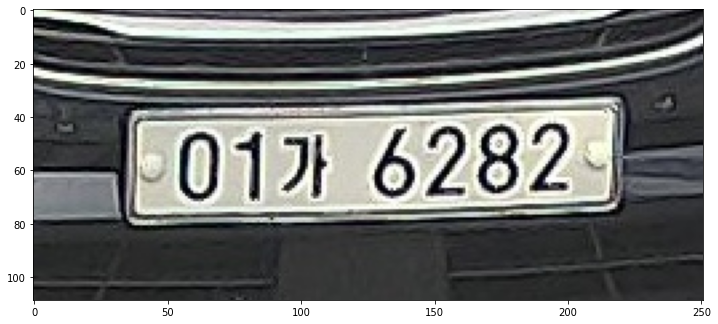

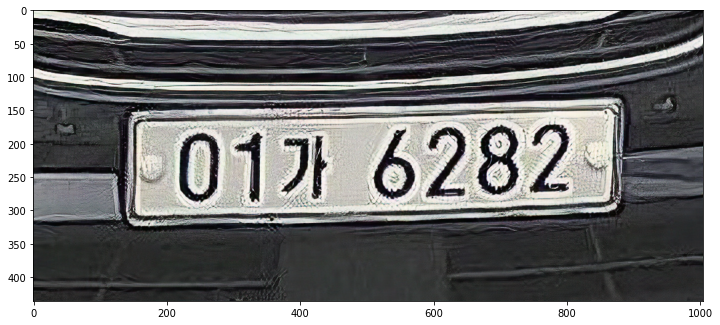

In [ ]:
hr_image = cv2.imread('/gdrive/My Drive/해커톤/자동차번호판OCR데이터/01가6282.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 10))
plt.imshow(hr_image)

srgan_hr = apply_srgan(hr_image)

plt.figure(figsize=(12, 10))
plt.imshow(srgan_hr)

In [ ]:
hr_image.shape

(109, 251, 3)

In [ ]:
srgan_hr.shape

(436, 1004, 3)

해상도 4배 상승

## 원본 이미지 프로세싱

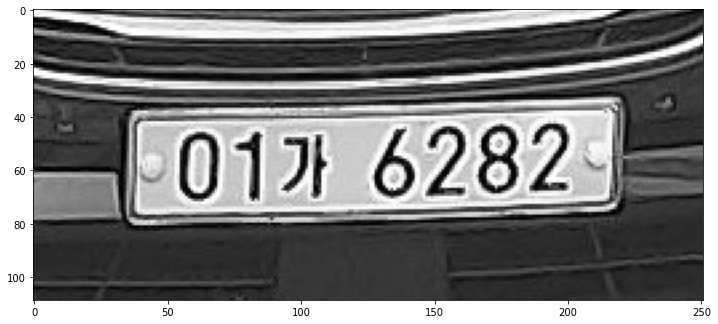

In [ ]:
gray = cv2.cvtColor(hr_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

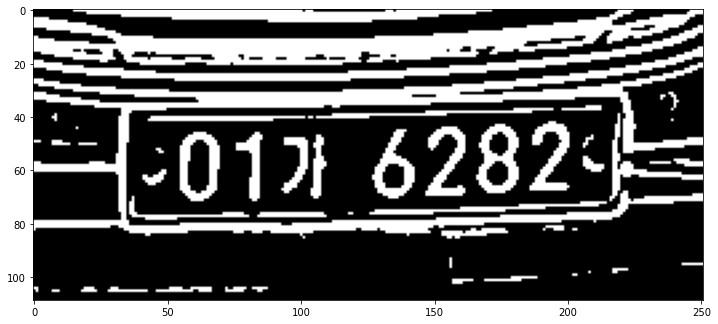

In [ ]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

원본 이미지 파일은 노이즈 없이 깔끔하다.

In [ ]:
cv2.imwrite("/gdrive/My Drive/해커톤/이미지프로세싱/1.jpg",img_thresh)

True

## SR 적용 후 이미지 프로세싱

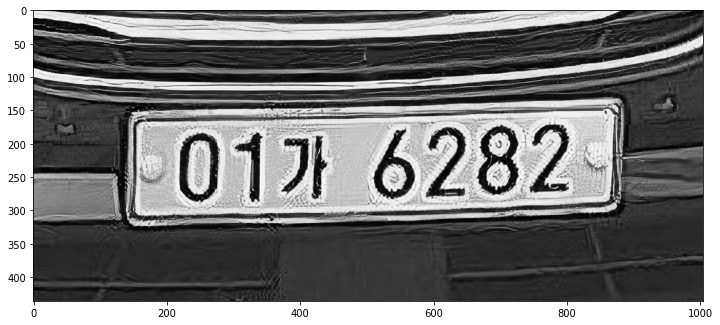

In [ ]:
gray = cv2.cvtColor(srgan_hr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

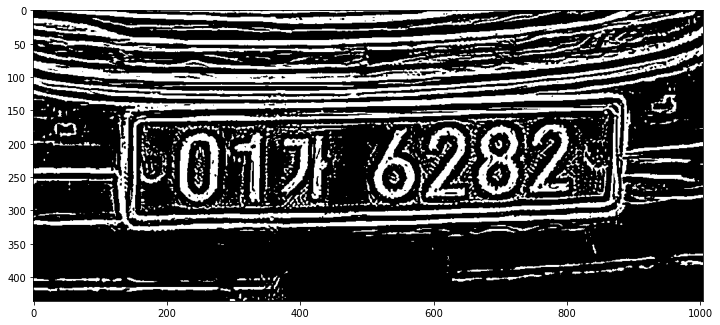

In [ ]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

SR을 적용하면 오히려 노이즈 증가한다.

In [ ]:
cv2.imwrite("/gdrive/My Drive/해커톤/이미지프로세싱/3.jpg",img_thresh)

True

## 보간법 적용후 이미지 프로세싱

In [ ]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    hr_image, 
    dsize=(hr_image.shape[1]*4, hr_image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [ ]:
bicubic_hr.shape

(436, 1004, 3)

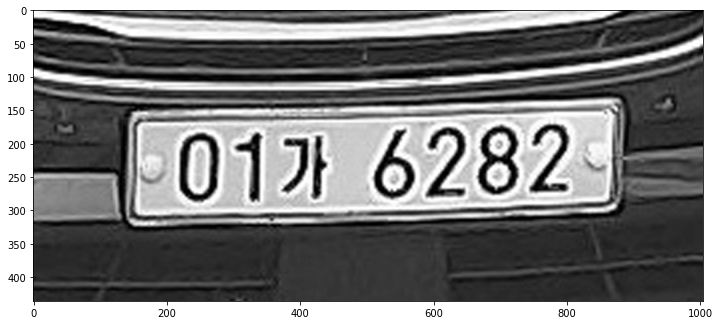

In [ ]:
gray = cv2.cvtColor(bicubic_hr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

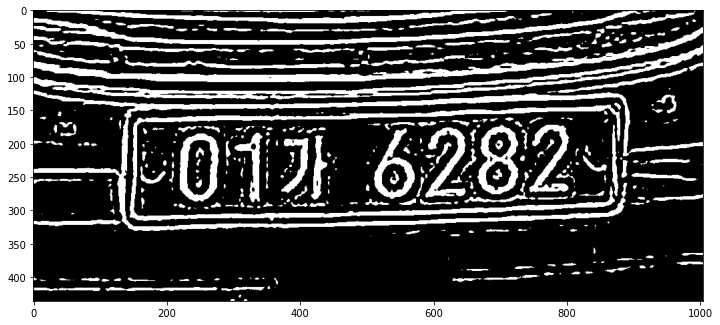

In [ ]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

보간법도 마찬가지로 노이즈가 증가한다.

In [ ]:
cv2.imwrite("/gdrive/My Drive/해커톤/이미지프로세싱/2.jpg",img_thresh)

True

# 구글 OCR로 결과 확인하기

In [ ]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

### 원본

In [ ]:
detect_text('/gdrive/My Drive/해커톤/이미지프로세싱/1.jpg') # 원본

Texts:

"012 6282
"

"012"

"6282"


### 보간법

In [ ]:
detect_text('/gdrive/My Drive/해커톤/이미지프로세싱/2.jpg') 

Texts:

"017 62824
"

"017"

"62824"


### 슈퍼 레졸루션

In [ ]:
detect_text('/gdrive/My Drive/해커톤/이미지프로세싱/3.jpg') 

Texts:

"01 6282
"

"01"

"6282"


# 실험결과
- 구글 OCR API로 일단 아무것도 정확하게는 인식하지 못했는데 그래도 육안으로는 원본이 가장 깔끔한 결과를 나타내었다. 그래서 이미지 프로세싱을 조금 더 발전시키면 정확도를 높일 수 있을 거라는 판단이 내려졌다.
- 해상도가 커지면 어쨌든 OCR의 처리속도도 느려지고 이미지 프로세싱 과정에서 노이즈가 발생하므로 SR과 보간법은 사용하지 않는 것이 좋다는 결론이 나왔다. 